In [ ]:
'''
Understand the basics of the dataset : L1000N1800/L1000N3600 at snapshot z=0.1
1. Total halo numbers in every mass bin in my interested redshifts
2. Randomly select the halos, see their mass map, X-ray bol lum maps
-> save the plots in fig/L1000N1800_z01/Xray_bol_02-2kev or fig/L1000N1800_z01/masses

'''




In [17]:
'''
Step1: Total halo numbers in every mass bin in my interested redshifts
L1000N1800, for z=0.1
'''

# L1000N1800
sim = 'L1000N1800'
snapnum = 77

# # L1000N3600
# sim = 'L1000N3600'
# snapnum = 78

import numpy as np 
import swiftsimio as sw
import h5py
import matplotlib.pyplot as plt

# load soap
reds = 0.1
with h5py.File(f"/cosma8/data/dp004/flamingo/Runs/{sim}/HYDRO_FIDUCIAL/SOAP/halo_properties_00{int(snapnum-reds/0.05)}.hdf5", 'r') as catalogue_soap:
    soap_ids = np.array(catalogue_soap["VR/ID"][()])
    m200c_sp = catalogue_soap["SO/200_crit/TotalMass"][()]
    # r200c_sp = catalogue_soap["SO/200_crit/SORadius"][()]
    gasmass_center = catalogue_soap["SO/200_crit/GasCentreOfMass"][()]
    # xray_bol_emilum = catalogue_soap["SO/200_crit/XRayLuminosityWithoutRecentAGNHeating"][()]
    # xray_bol_phlum = catalogue_soap["SO/200_crit/XRayPhotonLuminosityWithoutRecentAGNHeating"][()]

# take halo mass btw 13-13.5 solar mass
mf_arr = np.arange(12.5, 16, 0.5)
halo_num_arr =  np.zeros(mf_arr.shape)

for i, mf in enumerate(mf_arr):
    msk = (m200c_sp < np.power(10,mf+0.5)) & (m200c_sp >= np.power(10,mf)) & (gasmass_center[:,0] > 50) & (gasmass_center[:,0] < 950) & (gasmass_center[:,1] > 50) & (gasmass_center[:,1] < 950) & (gasmass_center[:,2] > 50) & (gasmass_center[:,2] < 950)
    halo_num_arr[i] = np.sum(msk)



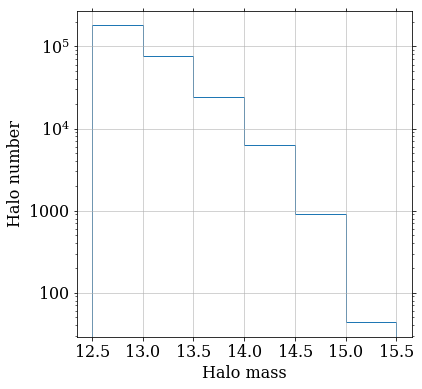

In [18]:
# make the hist plot

plt.figure(figsize=(6,6))
plt.stairs(halo_num_arr[:-1], mf_arr)

plt.yscale('log')
plt.ylabel('Halo number')
plt.xlabel('Halo mass')
plt.xticks(mf_arr)
plt.show()
plt.close()

In [59]:
import healpy as hp
def cartproj_map(mapdata,vector, r=5, xsize=600, nside=4096):
    '''
    Parameters
    ----------
    halo: string of halo_id
    r: fov radius : degree
    xsize: pixel number
    nside: integral
    '''
    xsize = 600 
    nside = 4096
    cartproj = hp.projector.CartesianProj(
        lonra=[-r , r ],
        latra=[-r , r ],
        # rot=hp.vec2ang(np.array([1,0,0]), lonlat=True), #bas
        rot= hp.vec2ang(vector, lonlat=True), #void
        # rot = hp.vec2ang(np.array([0.29619813,  0.17101007, -0.93969262]), lonlat=True), # strange_halo
        xsize=xsize,
    )
    pR = cartproj.projmap(mapdata, lambda x,y,z:hp.vec2pix(nside,x,y,z))
    return pR

In [2]:
#  Select 25 random halo in each mass bin and plot them (all projected along z axis)
'''
Step1: Total halo numbers in every mass bin in my interested redshifts
L1000N1800, for z=0.1
'''


import numpy as np 
import swiftsimio as sw
import h5py
import matplotlib.pyplot as plt
from unyt import msun, kpc
from swiftsimio.visualisation.projection import project_gas
from swiftsimio import load
from matplotlib.colors import LogNorm
from swiftsimio.visualisation import project_gas_pixel_grid

from scipy import stats
from datetime import datetime

import os

today = datetime.today().strftime('%Y-%m-%d')
os.makedirs("../../fig/halo_mass_dens_maps/", exist_ok=True)
# define redshifts
reds = 0.1


# L1000N1800
sim = 'L1000N1800'
snapnum = 77
cat_idx = f"00{int(snapnum-reds/0.05)}"

# # L1000N3600
# sim = 'L1000N3600'
# snapnum = 78

# define catalogues positions
work_dir = f"/cosma8/data/dp004/dc-chen3/work/bin/halo-radial-profile-in-snapshot"
basic_dir = f"/cosma8/data/dp004/flamingo/Runs/{sim}/HYDRO_FIDUCIAL"
soap_dir = f"{basic_dir}/SOAP"
snapshot_dir = f"{basic_dir}/snapshots_downsampled"

# load snapshot data
with h5py.File(f"{snapshot_dir}/flamingo_{cat_idx}.hdf5", 'r') as f:
    coords = f['GasParticles/Coordinates'][()]
    mass_map = f['GasParticles/Masses'][()]

# load soap catalogue
with h5py.File(f"{soap_dir}/halo_properties_{cat_idx}.hdf5", 'r') as catalogue_soap:
    soap_ids = np.array(catalogue_soap["VR/ID"][()])
    m200c_sp = catalogue_soap["SO/200_crit/TotalMass"][()]
    r200c_sp = catalogue_soap["SO/200_crit/SORadius"][()] * (1+reds)
    centers_of_potential = catalogue_soap["VR/CentreOfPotential"][()]
    gasmasscenters = catalogue_soap["SO/200_crit/GasCentreOfMass"][()] * (1+reds)
    # BH_center = catalogue_soap["SO/200_crit/MostMassiveBlackHolePosition"][()] * (1+reds) 
    
centers_inuse = gasmasscenters
# take halo mass btw 13-13.5 solar mass
mf_arr = np.arange(14, 15.5, 0.5)
# mf_arr = np.array([14.5,15])
halo_num_arr =  np.zeros(mf_arr.shape)

# set the random seed, draw 25 radom halos from each mass bin
np.random.seed(0)
halonum = 25


for i, mf in enumerate(mf_arr):
    msk = (m200c_sp < np.power(10,mf+0.5)) & (m200c_sp >= np.power(10,mf)) & (centers_inuse[:,0] > 50) & (centers_inuse[:,0] < 950) & (centers_inuse[:,1] > 50) & (centers_inuse[:,1] < 950) & (centers_inuse[:,2] > 50) & (centers_inuse[:,2] < 950)
    halo_num_arr[i] = np.sum(msk)
    halo_sel_ids = soap_ids[msk][np.random.randint(np.sum(msk), size=halonum)]
    
    centers = centers_inuse[np.isin(soap_ids, halo_sel_ids)]
    r200c_sel = r200c_sp[np.isin(soap_ids, halo_sel_ids)]

    fig,ax = plt.subplots(5,5,figsize = (25,25))
    plt.suptitle(f"1e{mf} $\\rm M_{{\odot}}/kpc^2$ cts map")
    #### Zoom in the downsampled map based to the halo position: range: 10r200c
    ## this is snapshot, you don't need to mollproj or cartproj!
    for k, r200c in enumerate(r200c_sel):
        spatial_msk = np.linalg.norm(coords - centers[k], axis =1) < 10*r200c
        sel_coords = coords[spatial_msk]
        # rebin the particles into bins
        bins_interval = 1 #kpc
        xbins = np.arange(centers[k][0]-5*r200c, centers[k][0]+5*r200c, bins_interval)
        ybins = np.arange(centers[k][1]-5*r200c, centers[k][1]+5*r200c, bins_interval)
        ret = stats.binned_statistic_2d(sel_coords[:,0], sel_coords[:,1],mass_map[spatial_msk]/1**2, 'sum', bins=[xbins, ybins])
        ax[k//5, k%5].imshow(ret.statistic, norm = LogNorm(), cmap="viridis")
    plt.xlabel('kpc')
    plt.ylabel('kpc')
    
    plt.savefig(f"1e{mf}_mass_div_kpc2_map_5r200c_z01_soap_{today}.png")
    plt.close()

    

In [7]:
# load soap catalogue
with h5py.File(f"{soap_dir}/halo_properties_{cat_idx}.hdf5", 'r') as catalogue_soap:
    gasmass_center = catalogue_soap["SO/200_crit/GasCentreOfMass"][()]

    
# define redshifts
reds = 0.1
# L1000N1800
sim = 'L1000N1800'
snapnum = 77
cat_idx = f"00{int(snapnum-reds/0.05)}"

# load vr catalogue
from velociraptor import load as load_catalogue
from velociraptor.particles import load_groups

catalogue_name = f"{basic_dir}/VR/catalogue_{cat_idx}/vr_catalogue_{cat_idx}"
vr_cat = load_catalogue(f"{catalogue_name}.properties.0")
vr_grp = load_groups(f"{catalogue_name}.catalog_groups.0", catalogue = vr_cat)
particles, __ = vr_grp.extract_halo(halo_id=0)

print(particles.x_mbp, particles.y_mbp, particles.z_mbp)
print(gasmass_center[0])

# fig,ax = plt.subplots( 1,3, figsize = (3,9))
# ax[0].scatter(gasmass_center[:,0], gasmass_center[:,1])
# ax[1].scatter(gasmass_center[:,0], gasmass_center[:,2])
# ax[2].scatter(gasmass_center[:,1], gasmass_center[:,2])


159.39042757459816 1000.0*kpc 213.84890030187086 1000.0*kpc 82.20931848368906 1000.0*kpc
[159.38805978 213.80427978  82.19235978]


In [21]:
print(r200c*20)

6.6796875


In [7]:
x = [0.1, 0.1, 0.1, 0.6]
y = [2.1, 2.6, 2.1, 2.1]
binx = [0.0, 0.5, 1.0]
biny = [2.0, 2.5, 3.0]
ret = stats.binned_statistic_2d(x, y, None, 'count', bins=[binx, biny])
ret.statistic

array([[2., 1.],
       [1., 0.]])

In [55]:
#  Select 25 random halo in each mass bin and plot them (all projected along z axis)
'''
Step1: Total halo numbers in every mass bin in my interested redshifts
L1000N1800, for z=0.1
'''

# L1000N1800
sim = 'L1000N1800'
snapnum = 77
cat_idx = f"00{int(snapnum-reds/0.05)}"

# # L1000N3600
# sim = 'L1000N3600'
# snapnum = 78

import numpy as np 
import swiftsimio as sw
import h5py
import matplotlib.pyplot as plt
from unyt import msun, kpc
from swiftsimio.visualisation.projection import project_gas
from swiftsimio import load
from matplotlib.colors import LogNorm


# define catalogues positions
basic_dir = f"/cosma8/data/dp004/flamingo/Runs/{sim}/HYDRO_FIDUCIAL"
soap_dir = f"{basic_dir}/SOAP"
snapshot_dir = f"{basic_dir}/snapshots_downsampled"

# load snapshot data
data = load(f"{snapshot_dir}/flamingo_{cat_idx}.hdf5")

# load soap catalogue
reds = 0.1
with h5py.File(f"{soap_dir}/halo_properties_{cat_idx}.hdf5", 'r') as catalogue_soap:
    soap_ids = np.array(catalogue_soap["VR/ID"][()])
    m200c_sp = catalogue_soap["SO/200_crit/TotalMass"][()]
    r200c_sp = catalogue_soap["SO/200_crit/SORadius"][()]
    gasmass_center = catalogue_soap["SO/200_crit/GasCentreOfMass"][()]

    # xray_bol_emilum = catalogue_soap["SO/200_crit/XRayLuminosityWithoutRecentAGNHeating"][()]
    # xray_bol_phlum = catalogue_soap["SO/200_crit/XRayPhotonLuminosityWithoutRecentAGNHeating"][()]

# take halo mass btw 13-13.5 solar mass
mf_arr = np.arange(12.5, 15.5, 0.5)
halo_num_arr =  np.zeros(mf_arr.shape)

# set the random seed, draw 25 radom halos from each mass bin
np.random.seed(0)
mass_filter = np.array([13.0])
halonum = 25


for i, mf in enumerate(mf_arr):
    msk = (m200c_sp < np.power(10,mf+0.5)) & (m200c_sp >= np.power(10,mf)) & (gasmass_center[:,0] > 50) & (gasmass_center[:,0] < 950) & (gasmass_center[:,1] > 50) & (gasmass_center[:,1] < 950) & (gasmass_center[:,2] > 50) & (gasmass_center[:,2] < 950)
    halo_num_arr[i] = np.sum(msk)
    halo_sel_ids = soap_ids[msk][np.random.randint(np.sum(msk), size=halonum)]
    
    centers = gasmass_center[np.isin(soap_ids, halo_sel_ids)]
    r200c_sel = r200c_sp[np.isin(soap_ids, halo_sel_ids)]

    #### Zoom in the downsampled map based to the halo position: range: 10r200c
    for i, r200c in enumerate(r200c_sel):
        test_size = r200c * 10

        region = [centers[i] + test_size, centers[i] - test_size, centers[i] + test_size, centers[i] - test_size] 
        
        # mass_map.convert_to_units(msun / kpc**2)

        plt.imshow(mass_map, norm = LogNorm(), cmap="viridis")
        plt.title(mf)
        plt.show()
        plt.close()

    

[1.7773438 1.6210938 1.5996094 ... 0.        0.        0.       ]


In [44]:
len(np.random.randint(np.sum(msk), size=halonum))

25

In [49]:
print(np.sum(msk), np.sum(np.isin(soap_ids, halo_sel_ids)), len(np.isin(soap_ids, halo_sel_ids)), len(soap_ids), len(halo_sel_ids))

180039 25 13635133 13635133 25


In [14]:
def basic_figure_style():
    SMALL_SIZE = 5*4                                       
    MEDIUM_SIZE = 8*2
    BIGGER_SIZE = 10*4

    plt.rc('font', size=MEDIUM_SIZE, family='serif')          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)                     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE, direction='out')    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE, direction='out')    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)                    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
    plt.rc('lines', linewidth=3) 
    plt.rc('axes', grid=True) #
    plt.rc('grid', alpha=0.7) #
    plt.rc('xtick', top=True)
    plt.rc('ytick', right=True)
    plt.rc('axes.formatter', use_mathtext=True, min_exponent=4, useoffset=False)
    plt.rc('figure', figsize='6, 6')                         # size of the figure, used to be '4, 3' in inches
    ######################################################
basic_figure_style()
cb = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']
